In [1]:
#all spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#all python imports
import numpy as np
import seaborn as sns

#instantiate the spark session
spark = SparkSession.builder.appName("EDA_heatmap").getOrCreate()

## Feature name encoding for ease of understading while model development later
###Some of the i0x## feature are renamed based on their characteristics as follows:
##### - last two letters are same as ## in the 'i0x##' in the original feature names.
##### - 'B_' before the last ## means that the feature is binary.
##### - 'T_' before the last ## means that the feature is Ternary.
##### - If a feature is prefixed with 'c_const', it remains constant thorughout a single cycle.
##### - If a feature is prefixed with 'P_const', it remains constant thorughout a single cell-protocol combination.
##### - If a feature starts with 'i0x' it varies throughout the data and it does not have any of the above characteristics.

In [3]:
#define schema with encoded feature names
myschema = StructType([
       StructField("time",DoubleType(),True),
       StructField("ocv",DoubleType(), True),
       StructField("di",DoubleType(),True),
       StructField("c_const_B_2d",IntegerType(),True),
       StructField("c_const_T_c4",DoubleType(),True),
       StructField("i0x91",DoubleType(),True),
       StructField("c_const_B_81",IntegerType(),True),
       StructField("c_const_B_40",IntegerType(),True),
       StructField("c_const_T_32",DoubleType(),True),
       StructField("B_65",IntegerType(),True),
       StructField("i0x2",DoubleType(),True),
       StructField("c_const_T_bc",DoubleType(),True),
       StructField("P_const_30",IntegerType(),True),
       StructField("P_const_9f",IntegerType(),True),
       StructField("c_const_B_6b",IntegerType(),True),
       StructField("c_const_B_9",IntegerType(),True),
       StructField("const_8f",IntegerType(),True),
       StructField("c_const_B_3b",IntegerType(),True),
       StructField("c_const_B_c9",IntegerType(),True),
       StructField("c_const_B_b2",IntegerType(),True),
       StructField("c_const_B_14",IntegerType(),True),
       StructField("c_const_B_76",IntegerType(),True),
       StructField("c_const_B_29",IntegerType(),True),
       StructField("P_const_2c",IntegerType(),True),
       StructField("i0xcd",DoubleType(),True),
       StructField("i0x28",DoubleType(),True),
       StructField("i0xb1",DoubleType(),True),
       StructField("i0x83",DoubleType(),True),
       StructField("i0x8c",DoubleType(),True),
       StructField("i0x6",DoubleType(),True),
       StructField("T_5a",DoubleType(),True),
       StructField("B_78",IntegerType(),True),
       StructField("i0xa7",DoubleType(),True),
       StructField("i0x2a",DoubleType(),True),
       StructField("i0x8a",DoubleType(),True),
       StructField("T_b6",DoubleType(),True),
       StructField("c_const_T_5",DoubleType(),True),
       StructField("i0x94",DoubleType(),True),
       StructField("i0x73",DoubleType(),True),
       StructField("average_di",DoubleType(),True),
       StructField("charge_duration",DoubleType(),True),
       StructField("cell_no", IntegerType(),True),
       StructField("protocol", StringType(),True),
       StructField("cycle",IntegerType(),True)])

#extract column names from schema
column_names = myschema.fieldNames()

In [4]:
#read csv file with all data
all_DF = spark.read.csv("/FileStore/tables/GBatteries_alldata.csv", inferSchema = True, header = True)

#create rdd to enforce new column names and create DF
all_rdd = all_DF.rdd.map(list)
all_DF = spark.createDataFrame(all_rdd, column_names).repartition(8).cache()

#materialize the all_DF
all_DF.count()

Out[3]: 1275400

In [5]:
display(all_DF.limit(5))

time,ocv,di,c_const_B_2d,c_const_T_c4,i0x91,c_const_B_81,c_const_B_40,c_const_T_32,B_65,i0x2,c_const_T_bc,P_const_30,P_const_9f,c_const_B_6b,c_const_B_9,const_8f,c_const_B_3b,c_const_B_c9,c_const_B_b2,c_const_B_14,c_const_B_76,c_const_B_29,P_const_2c,i0xcd,i0x28,i0xb1,i0x83,i0x8c,i0x6,T_5a,B_78,i0xa7,i0x2a,i0x8a,T_b6,c_const_T_5,i0x94,i0x73,average_di,charge_duration,cell_no,protocol,cycle
1.578669087548E9,3912.0,0.5781990521327014,0.0,1.0,0.043478260869565216,0.0,1.0,0.0,1.0,0.08318053008834805,0.09090909090909093,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,5.002501250625311E-4,0.851063829787234,0.1559862457017818,0.674,0.4722222222222222,0.9090909090909092,0.0,1.0,0.0847457627118644,0.031719532554257086,0.028571428571428567,0.75,0.0,6.668889629876625E-4,6.002400960384152E-4,0.5851815621257854,55.8,9,f89b0ae3c67c80e30c07089eb90ab50ad0c817d39f05861fa9d9962ff45647d5,376
1.577035460059E9,4145.0,0.5639810426540285,0.0,1.0,0.043478260869565216,0.0,1.0,0.0,1.0,0.08318053008834805,0.09090909090909093,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,5.002501250625311E-4,0.851063829787234,0.1559862457017818,0.674,0.4722222222222222,0.9090909090909092,0.0,1.0,0.0847457627118644,0.031719532554257086,0.028571428571428567,0.75,0.0,6.668889629876625E-4,6.002400960384152E-4,0.5808172869784246,56.8,9,f89b0ae3c67c80e30c07089eb90ab50ad0c817d39f05861fa9d9962ff45647d5,206
1.586415094975E9,4192.0,0.5545023696682464,0.0,0.0,0.2608695652173913,0.0,1.0,1.0,1.0,0.08318053008834805,0.09090909090909093,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.851063829787234,1.0,0.76,0.3888888888888889,0.9090909090909092,0.0,0.0,0.0,0.031719532554257086,0.061224489795918366,0.0,1.0,1.0,1.0,0.5569109520864161,15.8,24,5f2ed209ddb21e76d6889ddee126c3df653f11488da0bc8ee9a641ba33a8155b,57
1.575172612065E9,4157.0,0.5687203791469194,0.0,1.0,0.043478260869565216,0.0,1.0,0.0,1.0,0.08318053008834805,0.09090909090909093,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,5.002501250625311E-4,0.851063829787234,0.1559862457017818,0.674,0.4722222222222222,0.9090909090909092,0.0,1.0,0.0847457627118644,0.031719532554257086,0.028571428571428567,0.75,0.0,6.668889629876625E-4,6.002400960384152E-4,0.5788945861572563,58.18333333333333,9,f89b0ae3c67c80e30c07089eb90ab50ad0c817d39f05861fa9d9962ff45647d5,19
1.579229783716E9,3604.0,0.5781990521327014,0.0,1.0,0.043478260869565216,0.0,1.0,0.0,1.0,0.08318053008834805,0.09090909090909093,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,5.002501250625311E-4,0.851063829787234,0.1559862457017818,0.674,0.4722222222222222,0.9090909090909092,0.0,1.0,0.0847457627118644,0.031719532554257086,0.028571428571428567,0.75,0.0,6.668889629876625E-4,6.002400960384152E-4,0.5874767638537658,56.2,9,f89b0ae3c67c80e30c07089eb90ab50ad0c817d39f05861fa9d9962ff45647d5,435


In [6]:
#name of the column
vector_col = "corr_features"

#create a column of features to used for calculating correaltion matrix
assembler = VectorAssembler(inputCols=[c for c in all_DF.columns if c not in {'di','time','ocv','average_di', 'charge_duration',  'cycle', 'cell_no', 'protocol'}], outputCol=vector_col)

#transform the all_DF to include feature column
corr_DF = assembler.transform(all_DF)

In [7]:
# get correlation matrix
matrix = Correlation.corr(corr_DF, "corr_features")

In [8]:
#collect the result as 2D array on driver jvm 
cor_mat = matrix.collect()[0]["pearson(corr_features)"].toArray()

In [9]:
#print the correlation matrix
print(cor_mat)

[[ 1. -0.01135505 -0.00299692 ... 0.05922836 -0.01050643
 -0.01066595]
 [-0.01135505 1. -0.83839878 ... 0.07699889 -0.23512059
 -0.24035958]
 [-0.00299692 -0.83839878 1. ... -0.18633892 0.22232626
 0.22677285]
 ...
 [ 0.05922836 0.07699889 -0.18633892 ... 1. 0.02027774
 0.01986559]
 [-0.01050643 -0.23512059 0.22232626 ... 0.02027774 1.
 0.99850819]
 [-0.01066595 -0.24035958 0.22677285 ... 0.01986559 0.99850819
 1. ]]

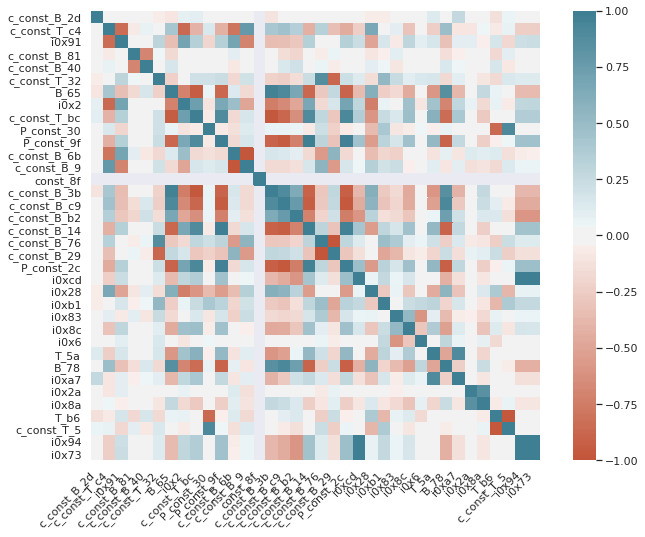

In [10]:
#visualize the correaltion matrix as heatmap
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(
    cor_mat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

ax.set_xticklabels(
    [c for c in all_DF.columns if c not in {'di','time','ocv','average_di', 'charge_duration',  'cycle', 'cell_no', 'protocol'}],
    rotation=45,
    horizontalalignment='right');

ax.set_yticklabels(
    [c for c in all_DF.columns if c not in {'di','time','ocv','average_di', 'charge_duration',  'cycle', 'cell_no', 'protocol'}],
    rotation=0);

In [11]:
#filter the feature with correlation higher than +-0.90
cor_mat2 = cor_mat.copy()
cor_mat2[np.abs(cor_mat2) < 0.90 ] = 0
cor_mat2

/local_disk0/tmp/1598642778057-0/PythonShell.py:3: RuntimeWarning: invalid value encountered in less
 
Out[10]: array([[1. , 0. , 0. , ..., 0. , 0. ,
 0. ],
 [0. , 1. , 0. , ..., 0. , 0. ,
 0. ],
 [0. , 0. , 1. , ..., 0. , 0. ,
 0. ],
 ...,
 [0. , 0. , 0. , ..., 1. , 0. ,
 0. ],
 [0. , 0. , 0. , ..., 0. , 1. ,
 0.99850819],
 [0. , 0. , 0. , ..., 0. , 0.99850819,
 1. ]])

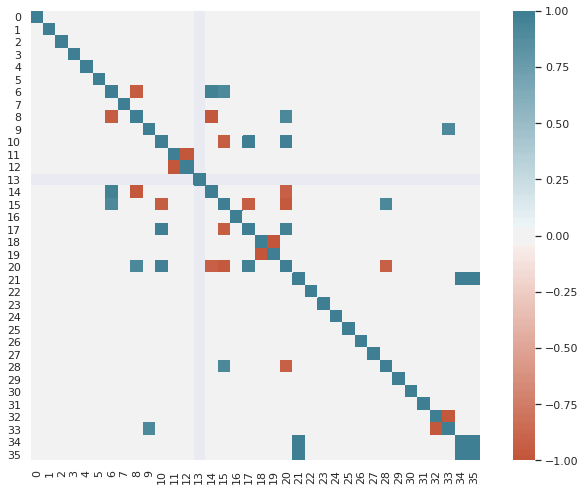

In [12]:
#visualize the filter matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(
    cor_mat2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    [c for c in srkDF.columns if c not in {'di','time','ocv','average_di', 'charge_duration',  'cycle', 'cell_no', 'protocol'}],
    rotation=45,
    horizontalalignment='right');

ax.set_yticklabels(
    [c for c in srkDF.columns if c not in {'di','time','ocv','average_di', 'charge_duration',  'cycle', 'cell_no', 'protocol'}],
    rotation=0);